In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
filepath = 'dichalcogenides_public/'
targets = pd.read_csv(filepath + 'targets.csv', index_col=0)

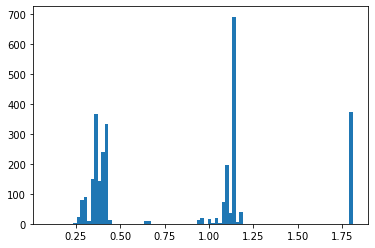

In [3]:
out = plt.hist(targets, bins=86)
plt.show()

In [4]:
(out[1][np.where(out[0]==692)[0][0]], out[1][np.where(out[0]==692)[0][0]+1])

(1.1319046511627906, 1.1518662790697674)

In [5]:
out[0]

array([  1.,   1.,   0.,   1.,   0.,   1.,   0.,   2.,  24.,  81.,  90.,
         9., 151., 366., 144., 239., 332.,  14.,   0.,   0.,   1.,   0.,
         1.,   0.,   0.,   0.,   0.,   8.,  11.,   0.,   1.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  12.,  20.,
         0.,  17.,   2.,  19.,   2.,  74., 196.,  35., 692.,   5.,  39.,
         1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 374.])

In [6]:
(692+374+366+332) / out[0].sum()

0.5947403910991234

In [7]:
import os

filepath_train = '../Data/dichalcogenides_public/structures/'
train_files = os.listdir(filepath_train)

filepath_test = '../Data/dichalcogenides_private/structures/'
test_files = os.listdir(filepath_test)

targets = pd.read_csv('../Data/dichalcogenides_public/targets.csv', index_col=0)

In [8]:
from itertools import zip_longest

def interleave(*a):
    # zip_longest filling values with as many NaNs as
    # values in second axis
    l = *zip_longest(*a, fillvalue=np.nan),
    # build a 2d array from the list
    out = np.concatenate(l)
    # return non-NaN values
    return np.array(out[~np.isnan(out)], dtype=int)

# Returns the square of the euclidean norm of 2D vector
def norm(v):
    return v[0] * v[0] + v[1] * v[1]

# Returns the vector joining l1[i,j] with the pixel in l2
# that is closer and has the same value
def movement_vector(l1, l2, i, j):
    if (l1[i,j] == l2[i,j]):
        return (0,0)
    
    at_loc = np.argwhere(l2==l1[i,j])
    min_dist = 10000
    v = (-100,-100)
    """for loc in at_loc:
        n = norm((loc[0]-i,loc[1]-j))
        if n < min_dist:
            v = (loc[0]-i,loc[1]-j)
            min_dist = n
    return v"""
    
    n, m = l2.shape
    for ii in range(n):
        for jj in range(m):
            if (l1[i,j] == l2[ii,jj]):
                n = norm((ii-i, jj-j))
                if n < min_dist:
                    v = (ii-i, jj-j)
                    min_dist = n
    return v

# Computes the distance between two layers as the sum of
# the norm of the movement vectors of all pixels
# A term accounting for the difference in the number of 
# imperfections is also added
def dist_layer(l1, l2):
    n, m = l1.shape
    d = 0
    for i in range(n):
        for j in range(m):
            v = movement_vector(l1, l2, i, j)
            if v[0] == -100:
                d += 15
            else:
                d += np.sqrt(norm(v))
    l1_se = np.sum(l1==34)
    l2_se = np.sum(l2==34)
    se_diff = np.abs(l1_se-l2_se)
    
    l1_void = np.sum(l1==0)
    l2_void = np.sum(l2==0)
    void_diff = np.abs(l1_void-l2_void)
    
    l1_w = np.sum(l1==74)
    l2_w = np.sum(l2==74)
    w_diff = np.abs(l1_w-l2_w)
    
    d += se_diff * 5 + void_diff * 5 + w_diff * 5
    return d

# Computes distance between l1 and l2 considering possible 
# transformation like rotations and symmetries
def dist_layer_sim(l1, l2):
    d = dist_layer(l1, l2)
    d_sim_h = dist_layer(l1, l2[:,::-1])
    d_sim_v = dist_layer(l1, l2[::-1,:])
    d_sim = dist_layer(l1, l2[::-1,::-1])
    d_rot_1 = dist_layer(l1, np.rot90(l2))
    d_rot_2 = dist_layer(l1, np.rot90(l2, k=2))
    d_rot_3 = dist_layer(l1, np.rot90(l2, k=3))
    return np.min([d, d_sim_v, d_sim_h, d_sim, d_rot_1, d_rot_2, d_rot_3])

# Computes distance between two crystals
def dist(im1, im2):
    d = dist_layer_sim(im1[:,:,1], im2[:,:,1])
    
    d00 = dist_layer_sim(im1[:,:,0], im2[:,:,0])
    d02 = dist_layer_sim(im1[:,:,0], im2[:,:,2])
    d20 = dist_layer_sim(im1[:,:,2], im2[:,:,0])
    d22 = dist_layer_sim(im1[:,:,2], im2[:,:,2])
    
    d += min(d00+d22, d02+d20)
    return d

In [10]:
%%time
k1, k2 = 0, 499

im1 = np.load(filepath + 'images/' + train_files[k1][:-5] + '.npy')
im2 = np.load(filepath + 'images/' + train_files[k2][:-5] + '.npy')

print('Crystal distance:', dist(im1, im2))
print('Band gap distance:', np.abs(targets.loc[train_files[k1][:-5]] - targets.loc[train_files[k2][:-5]])[0])

Crystal distance: 31.650281539872886
Band gap distance: 0.6669
CPU times: user 16.6 ms, sys: 2.31 ms, total: 18.9 ms
Wall time: 19.5 ms


In [11]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

  0%|          | 0/2966 [00:00<?, ?it/s]

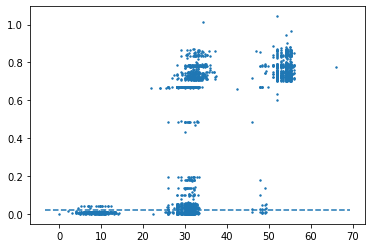

Nearest neighbour is: 637


  0%|          | 0/2966 [00:00<?, ?it/s]

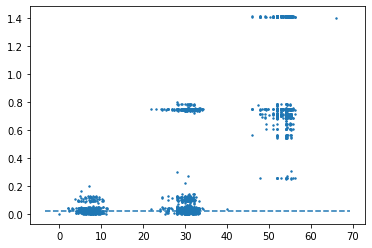

Nearest neighbour is: 1850


  0%|          | 0/2966 [00:00<?, ?it/s]

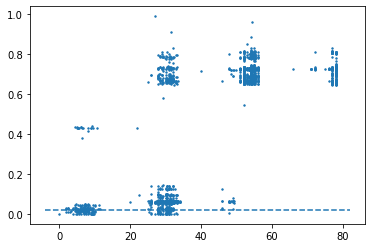

Nearest neighbour is: 152


  0%|          | 0/2966 [00:00<?, ?it/s]

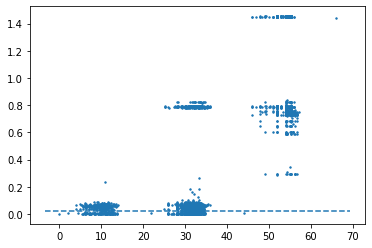

Nearest neighbour is: 1960


  0%|          | 0/2966 [00:00<?, ?it/s]

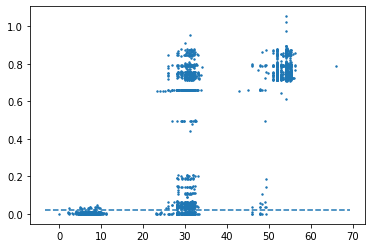

Nearest neighbour is: 1178


  0%|          | 0/2966 [00:00<?, ?it/s]

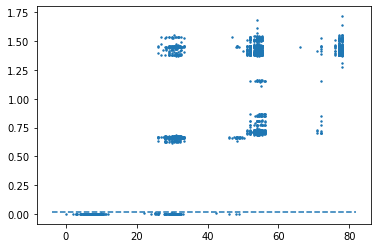

Nearest neighbour is: 2843


  0%|          | 0/2966 [00:00<?, ?it/s]

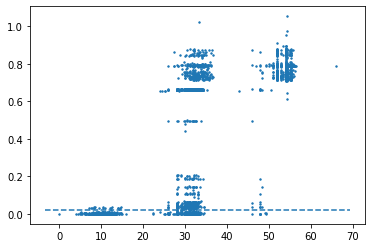

Nearest neighbour is: 1448


  0%|          | 0/2966 [00:00<?, ?it/s]

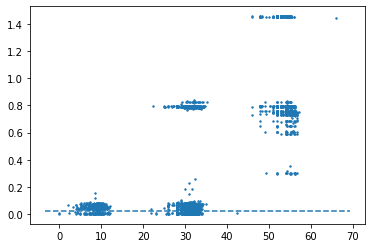

Nearest neighbour is: 1767


  0%|          | 0/2966 [00:00<?, ?it/s]

In [ ]:
from tqdm.notebook import tqdm

for k1 in range(1,10):
    im1 = np.load(filepath + 'images/' + train_files[k1][:-5] + '.npy')
    crystal_dist = []
    band_gap_dist = []
    min_k = -1
    min_d = 100
    # Compute distances
    for k2 in tqdm(range(2966)):
        im2 = np.load(filepath + 'images/' + train_files[k2][:-5] + '.npy')
        d = dist(im1, im2)
        if d < min_d and k2 != k1:
            min_k = k2
            min_d = d
        crystal_dist.append(d)
        band_gap_dist.append(np.abs(targets.loc[train_files[k1][:-5]] - targets.loc[train_files[k2][:-5]])[0])

    # Save distances
    aux_dist = pd.DataFrame(data={'dist':crystal_dist}, index=train_files)
    aux_dist.to_csv(filepath + 'distances/' + train_files[k1][:-5] + '.csv')

    # Visualize distances
    plt.scatter(crystal_dist, band_gap_dist, s=2)
    abline(0,0.02)
    plt.show()
    print('Nearest neighbour is:', min_k)

In [14]:
y = np.array(targets.index)
x = np.array([x[:-5] for x in train_files])

index = np.argsort(x)
sorted_x = x[index]
sorted_index = np.searchsorted(sorted_x, y)

yindex = np.take(index, sorted_index, mode="clip")
mask = x[yindex] != y

result = np.ma.array(yindex, mask=mask)

In [15]:
targets['id_number'] = result

In [16]:
targets[targets.band_gap>1.1]

,band_gap,id_number
_id,,
6141cf1051c1cbd9654b8872,1.1102,2965
6141cf11cc0e69a0cf28ab35,1.1484,2608
6141cf11b842c2e72e2f2d48,1.8068,2110
6141cf11cc0e69a0cf28ab37,1.1475,548
6141cf12b842c2e72e2f2d4a,1.8075,1535
...,...,...
6145b8f24e27a1844a5f0af6,1.1485,245
6145c3fa4e27a1844a5f0af8,1.1467,2899
6145c7034e27a1844a5f0afa,1.1374,485
